## Cycle GAN with Pytorch
see [towards data science](https://towardsdatascience.com/cycle-gan-with-pytorch-ebe5db947a99) from Bjorn Hansen

and [keras example](https://keras.io/examples/generative/cyclegan/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def interval_mask(start, stop, length):
    mask = np.zeros(length, dtype=bool)
    mask[start:stop] = True
    return mask

0.5

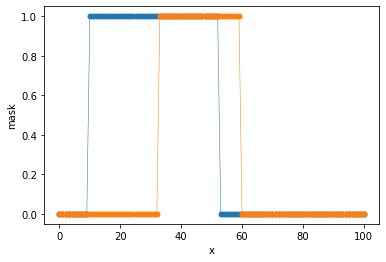

In [3]:
plt.plot(interval_mask(10, 53, 101), marker='.', markersize=10, lw=0.5)
plt.plot(interval_mask(33, 60, 101), marker='.', markersize=10, lw=0.5)
plt.xlabel('x'); plt.ylabel('mask');.5

In [4]:
def pulse(p, length=1000, x_max=10., noise_level=0., plot=False):
    t_0, t_1, t_2, t_3, t_0p = p[0], sum(p[:2]), sum(p[:3]), sum(p[:4]), p[-1]
    i_0 = interval_mask(0, t_0, length)
    i_1 = interval_mask(t_0, t_1, length)
    i_2 = interval_mask(t_1, t_2, length)
    i_3 = interval_mask(t_2, t_3, length)
    i_tot = interval_mask(t_0, t_3, length)
        
    x = np.linspace(0, x_max, length)
    
    y = np.zeros_like(x)
    y[i_0] = x[i_0]
    y[i_1] = y[t_0-1] + np.sin((x[i_1] - x[t_0]) / (x[t_1-1] - x[t_0]) * np.pi) 
    y[i_2] = y[t_1-1] + (np.cos((x[i_2] - x[t_1]) / (x[t_2-1] - x[t_1]) * np.pi * 3.) - 1.)* 0.2
    y[i_3] = y[t_2-1] + (np.cos((x[i_3] - x[t_2]) / (x[t_3-1] - x[t_2]) * np.pi * 4.)**2 - 1.)* 0.2
    
    y[i_tot] += np.sin((x[i_tot] - x[t_0p]) / (x[t_3-1] - x[t_0p]) * np.pi * 5.) * 0.2
    
    y[t_3:] = y[t_3-1] - y[t_3-1] * x[:length - t_3] / (length - t_3) /x_max*length
    
    if noise_level:
        y += np.random.randn(len(y)) * noise_level
        y = np.maximum(y, 0.)
    
    if plot:
    
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

        ax2.plot(x, i_0, marker='.', markersize=10, lw=0.5, label='$i_0$')
        ax2.plot(x, i_1, marker='.', markersize=10, lw=0.5, label='$i_1$')
        ax2.plot(x, i_2, marker='.', markersize=10, lw=0.5, label='$i_2$')
        ax2.plot(x, i_3, marker='.', markersize=10, lw=0.5, label='$i_3$')
        ax2.plot(x, i_tot, marker='.', markersize=10, lw=0.5, label='$i_{tot}$', zorder=0)

        ax1.plot(x[i_0], y[i_0])
        ax1.plot(x[i_1], y[i_1])
        ax1.plot(x[i_2], y[i_2])
        ax1.plot(x[i_3], y[i_3])    
        ax1.plot(x, y, zorder=0)
        
        ax2.set_xlabel('x')
        ax2.set_ylabel('mask')
        ax2.legend()
        
        ax1.set_ylabel('pulse')

    return y, (i_0, i_1, i_2, i_3, i_tot)

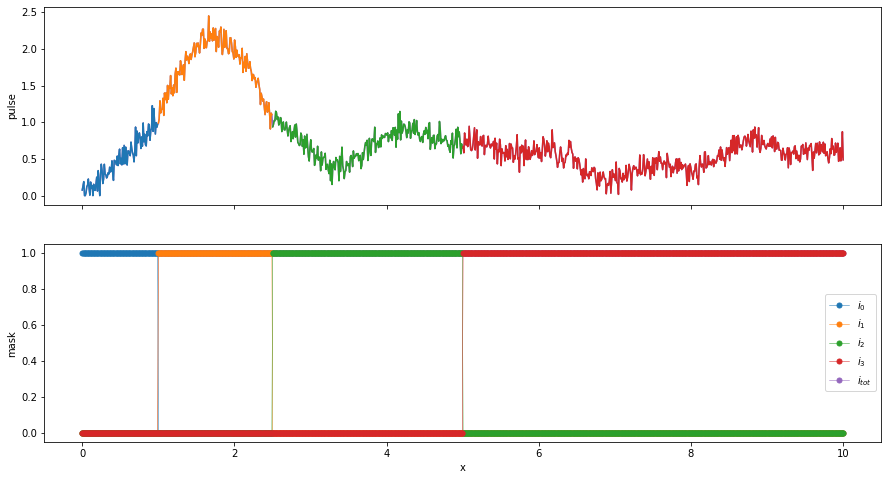

In [5]:
y, _ = pulse([100, 150, 250, 500, 80], 1000, plot=True, noise_level=0.1)

In [6]:
PULSE_LEGNTH = 64
PULSE_RANGE = 10.
N_PARAMS = 5
NOISE_LEVEL = 0.05

MIN_I0, MAX_I0 = 4, 8
MIN_I1, MAX_I1 = 8, 16
MIN_I2, MAX_I2 = 8, 24
MIN_I3, MAX_I3 = 16, 32

In [7]:
def random_parameters(min_intervals, max_intervals, length=100):
    intervals = [np.random.randint(min_intervals[i], max_intervals[i] + 1) for i in range(len(max_intervals))]
    for i in range(len(intervals)):
        if sum(intervals[:i+1]) > PULSE_LEGNTH:
            intervals[i] -= (sum(intervals[:i+1]) - PULSE_LEGNTH + 1)
    
    intervals.append(np.random.randint(0, sum(max_intervals[:2])))  # t0'
    
    return intervals

for _ in range(1000):
    l = random_parameters([MIN_I0, MIN_I1, MIN_I2, MIN_I3], [MAX_I0, MAX_I1, MAX_I2, MAX_I3], length=PULSE_LEGNTH)
    x = sum(l[:-1])
    assert x <= PULSE_LEGNTH    

## Create Dataset

In [8]:
N_DATA = 10000

In [9]:
parameters = np.array([
    random_parameters([MIN_I0, MIN_I1, MIN_I2, MIN_I3], [MAX_I0, MAX_I1, MAX_I2, MAX_I3], length=PULSE_LEGNTH)
    for _ in range(N_DATA)
])

In [10]:
pulse_data = [
    pulse(p, length=PULSE_LEGNTH, x_max=PULSE_RANGE, noise_level=NOISE_LEVEL)
    for p in parameters
]

pulses = np.array([p for p, i in pulse_data])
intervals = np.array([i for p, i in pulse_data])

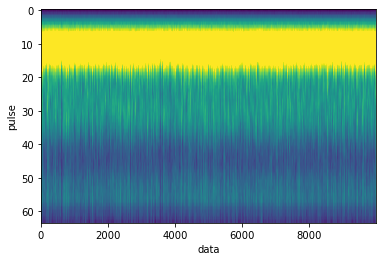

In [11]:
plt.imshow(pulses.T, aspect=1e2, vmax=1, vmin=0)
plt.xlabel('data')
plt.ylabel('pulse')
plt.show()

## Building blocks used in the CycleGAN

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [13]:
def get_pulse_to_params_model(pulse_length, n_params, 
                              conv_stack=[1], conv_activation=['relu'],
                              dense_stack=[128], dense_activation=['relu'], 
                              ):
    
    pulse = layers.Input((pulse_length,))
    x = pulse

    if conv_stack:
        x = layers.Reshape((-1, 1))(x)
        
        for f in conv_stack:
            x = layers.Conv1D(f, kernel_size=3, activation='sigmoid')(x)
            x = layers.BatchNormalization()(x)
    
        x = layers.Flatten()(x)

    
    for units, activation in zip(dense_stack, dense_activation):
        x = layers.Dense(units, activation=activation)(x)
        x = layers.BatchNormalization()(x)
    
    x = layers.Dense(n_params, activation='sigmoid')(x)
    params = layers.Lambda(lambda s: s*pulse_length)(x)
    
    return Model(pulse, params, name="generator_G")


gen_G = get_pulse_to_params_model(PULSE_LEGNTH, N_PARAMS, 
                                  conv_stack=[16, 16],
                                  conv_activation=['relu', 'relu'],
                                  dense_stack=[128, 128], 
                                  dense_activation=['relu', 'relu']
                                 )
gen_G.summary()

Model: "generator_G"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 62, 16)            64        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 16)            64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 16)            784       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64        
_________________________________________________________________
flatten (Flatten)            (None, 960)               

In [21]:
def get_pulse_to_puplse_model(pulse_length, max_pulse=10.,
                              conv_stack=[1], conv_activation=['relu'],
                              dense_stack=[128], dense_activation=['relu'], 
                              ):
    
    pulse = layers.Input((pulse_length,))
    x = pulse

    if conv_stack:
        x = layers.Reshape((-1, 1))(x)
        
        for f in conv_stack:
            x = layers.Conv1D(f, kernel_size=3, activation='sigmoid')(x)
            x = layers.BatchNormalization()(x)
    
        x = layers.Flatten()(x)

    
    for units, activation in zip(dense_stack, dense_activation):
        x = layers.Dense(units, activation=activation)(x)
        x = layers.BatchNormalization()(x)
    
    x = layers.Dense(pulse_length, activation='sigmoid')(x)
    pulse_prime = layers.Lambda(lambda s: s*max_pulse)(x)

    return Model(pulse, pulse_prime, name="identity_G")


id_G = get_pulse_to_puplse_model(PULSE_LEGNTH, 
                                 conv_stack=[16, 16],
                                 conv_activation=['relu', 'relu'],
                                 dense_stack=[128, 128], 
                                 dense_activation=['relu', 'relu']
                                )
id_G.summary()

Model: "identity_G"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 62, 16)            64        
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 16)            64        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 60, 16)            784       
_________________________________________________________________
batch_normalization_15 (Batc (None, 60, 16)            64        
_________________________________________________________________
flatten_4 (Flatten)          (None, 960)               0

In [14]:
def get_params_to_pulse_model(n_params, pulse_length, max_pulse=10.,
                              dense_stack=[128], dense_activation=['relu'], 
                              conv_stack=[16, 16]
                              ):
    
    params = layers.Input((n_params,))
    x = params
    
    for units, activation in zip(dense_stack, dense_activation):
        x = layers.Dense(units, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        
    if conv_stack:
        x = layers.Reshape((-1, 1))(x)
        
        for f in conv_stack:
            x = layers.Conv1D(f, kernel_size=3, activation='sigmoid')(x)
            x = layers.BatchNormalization()(x)
    
        x = layers.Flatten()(x)
    
    x = layers.Dense(pulse_length, activation='sigmoid')(x)
    pulse = layers.Lambda(lambda s: s*max_pulse)(x)
    
    return Model(params, pulse, name="generator_F")


gen_F = get_params_to_pulse_model(N_PARAMS, PULSE_LEGNTH,
                                  dense_stack=[128, 128], 
                                  dense_activation=['relu', 'relu']
                                 )

gen_F.summary()

Model: "generator_F"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               768       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 126, 16)           

In [23]:
def get_params_to_params_model(n_params, pulse_length, 
                               dense_stack=[128], dense_activation=['relu'], 
                               conv_stack=[16, 16]
                               ):
    
    params = layers.Input((n_params,))
    x = params
    
    for units, activation in zip(dense_stack, dense_activation):
        x = layers.Dense(units, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        
    if conv_stack:
        x = layers.Reshape((-1, 1))(x)
        
        for f in conv_stack:
            x = layers.Conv1D(f, kernel_size=3, activation='sigmoid')(x)
            x = layers.BatchNormalization()(x)
    
        x = layers.Flatten()(x)
    
    x = layers.Dense(n_params, activation='sigmoid')(x)
    params_prime = layers.Lambda(lambda s: s*pulse_length)(x)
    
    return Model(params, params_prime, name="identity_F")


id_F = get_params_to_params_model(N_PARAMS, PULSE_LEGNTH,
                                  dense_stack=[128, 128], 
                                  dense_activation=['relu', 'relu']
                                 )

id_F.summary()

Model: "identity_F"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               768       
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)               512       
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_23 (Batc (None, 128)               512       
_________________________________________________________________
reshape_6 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 126, 16)           6

In [15]:
def get_pulse_discriminator(pulse_length,  
                            conv_stack=[16], conv_activation=['relu'],
                            dense_stack=[128], dense_activation=['relu'], 
                            ):
    
    pulse = layers.Input((pulse_length,))
    x = pulse

    if conv_stack:
        x = layers.Reshape((-1, 1))(x)
        
        for f in conv_stack:
            x = layers.Conv1D(f, kernel_size=3, activation='sigmoid')(x)
            x = layers.BatchNormalization()(x)
    
        x = layers.Flatten()(x)

    
    for units, activation in zip(dense_stack, dense_activation):
        x = layers.Dense(units, activation=activation)(x)
        x = layers.BatchNormalization()(x)
    
    discrimination = layers.Dense(1, activation='sigmoid')(x)
    return Model(pulse, discrimination, name='discriminator_X')


disc_X = get_pulse_discriminator(PULSE_LEGNTH)
disc_X.summary()

Model: "discriminator_X"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 62, 16)            64        
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 16)            64        
_________________________________________________________________
flatten_2 (Flatten)          (None, 992)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               127104    
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)           

In [16]:
def get_params_discriminator(n_params, 
                             dense_stack=[128, 128], dense_activation=['relu', 'relu'], 
                             conv_stack=[16], conv_activation=['relu']
                             ):
    
    params = layers.Input((n_params,))
    x = params
    
    for units, activation in zip(dense_stack, dense_activation):
        x = layers.Dense(units, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        
    if conv_stack:
        x = layers.Reshape((-1, 1))(x)
        
        for f, a in zip(conv_stack, conv_activation):
            x = layers.Conv1D(f, kernel_size=3, activation=a)(x)
            x = layers.BatchNormalization()(x)
    
        x = layers.Flatten()(x)
    
    discrimination = layers.Dense(1, activation='sigmoid')(x)
    return Model(params, discrimination, name='discriminator_Y')


disc_Y = get_params_discriminator(N_PARAMS, conv_stack=[16, 16], conv_activation=['relu', 'relu'])
disc_Y.summary()

Model: "discriminator_Y"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               768       
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
reshape_3 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 126, 16)       

## Build GAN

In [24]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        identity_G,
        identity_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.id_G = identity_G
        self.id_F = identity_F 
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        id_G_optimizer,
        id_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.id_G_optimizer = id_G_optimizer
        self.id_F_optimizer = id_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(fake_y, training=True)  # TODO: make idy_F: x -> x
            #same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(fake_x, training=True)  # TODO: make idy_G: y -> y
            #same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


## Train the end-to-end model

In [26]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, 
    generator_F=gen_F, 
    identity_G=id_G,
    identity_F=id_F,
    discriminator_X=disc_X, 
    discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    id_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    id_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Callbacks
# plotter = GANMonitor()
#checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
#model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath
#)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    pulses, parameters, 
    batch_size=32,
    epochs=10,
    # callbacks=[model_checkpoint_callback],  # plotter],
)

Epoch 1/10
313/313 [==============================] - 36s 62ms/step - G_loss: 16.7998 - F_loss: 1.9761 - D_X_loss: 0.2504 - D_Y_loss: 0.0602
Epoch 2/10
313/313 [==============================] - 22s 69ms/step - G_loss: 16.6039 - F_loss: 1.9547 - D_X_loss: 0.2505 - D_Y_loss: 0.0623
Epoch 3/10
313/313 [==============================] - 21s 67ms/step - G_loss: 16.1482 - F_loss: 1.9378 - D_X_loss: 0.2501 - D_Y_loss: 0.0552
Epoch 4/10
313/313 [==============================] - 19s 59ms/step - G_loss: 16.0798 - F_loss: 1.9180 - D_X_loss: 0.2501 - D_Y_loss: 0.0814
Epoch 5/10
313/313 [==============================] - 20s 64ms/step - G_loss: 15.9678 - F_loss: 1.9353 - D_X_loss: 0.2503 - D_Y_loss: 0.0812
Epoch 6/10
313/313 [==============================] - 20s 62ms/step - G_loss: 15.4279 - F_loss: 1.9085 - D_X_loss: 0.2501 - D_Y_loss: 0.0840
Epoch 7/10
313/313 [==============================] - 16s 52ms/step - G_loss: 15.4017 - F_loss: 1.9018 - D_X_loss: 0.2501 - D_Y_loss: 0.0679
Epoch 8/10
31